# **Sampling from the Solution Space of Genome-Scale Metabolic Models**

By [Haris Zafeiropoulos](https://hariszaf.github.io/) and [Daniel Rios Garza](https://danielriosgarza.github.io/) -- July, 2024

This notebook accompanies our chapter on the *“Flux Balance Analysis”* book, to be published in the protocol series Methods in Molecular Biology, by Springer Nature.

## **Setting working space**

You can either launch a Codespace based on this repository or run the project locally on your machine.

* **codespace**: Quick and easy to get started. Ideal for initial exploration, but may limit your ability to run custom experiments later on.

* **local**: Requires some setup and may involve troubleshooting environment issues, but gives you full control. Recommended if you plan to use your own data or customize the workflow later.



Here is how to go for each of those two cases.

### **Build a codespace**

To fire a codespace, you will need a GitHub account and then from our [GitHub repo](https://github.com/hariszaf/metabolic_toy_model/tree/sampling), use the `sampling` branch to create your codespace.

* First, click on the arrow on the `Code` button
* then, click on `Codespaces`
* and on the three dots `...`, to create a `New with options...`

![](files/figs/codespace-fire.png)

After you make sure you have the configuration as in the following picture, you may fire your codespace by clicking on the `Create codespace` button:

![](./files/figs/codespace-conf.png)

> **Advanced Tip**
>
> The [`devcontainer.json`](.devcontainer/devcontainer.json) describes the configuration of the codespace to be built. 
> 
> If you pay close attention, you will realise what you would need to make sure for your local build (see next paragraph).

### **Creating a Conda environment**

Here, we assume you have Miniconda or Anaconda installed in your machine. 

If you don't, you can follow [this tutorial](https://eduand-alvarez.medium.com/setting-up-anaconda-on-your-windows-pc-6e39800c1afb).

1. Create a Conda environment using Python 3.10 and a name of your choice; in this example, we'll call our environment `sampling`:

```conda create -n sampling -y python=3.10```

2) Activate your environment


```conda activate sampling```

3. We will be using `dingo` for flux sampling on the solution space of a metabolic model. `dingo` requires `PySPQR`; a module that wraps the [SuiteSparseQR](https://people.engr.tamu.edu/davis/suitesparse.html) decomposition function, but comes with a bunch of hard dependencies, based on your operating system. See [here](https://github.com/yig/PySPQR?tab=readme-ov-file#installation) for more. In the following, we assume you are working on Linux and that you have `sudo` rights:

```
sudo apt-get update -y
sudo apt-get install -y libsuitesparse-dev
```

4. You can now install the Python libraries required:

```pip install -r requirements.txt```

You may need the `--user` flag for this step:

```pip install -r requirements.txt --user```

5. You are now ready to go for it! 

In case you are working on VS Code or any other IDLE, make sure to set the kernel of the notebook to the `conda` environment you just built.

For example, if using VS Code, when you will try to run the first chunk of code, you will get a message like this:

![](./files/figs/select_kernel.png)

Then, you can click `Select Another Kernel... > Python Environments...` and you should look for the name of the environment you gave earlier, in our case `sampling`.

However, it's quite possible that IDLE will recognize the new environment after you close and relaunch it. 

## **Intro**

### **Bio**

We assume the reader/user is already familiar with the basic concepts of metabolic modeling and the basics of the `cobrapy` library. 

If this is not the case, you may **first** go through our according material on [this branch](), we were able to come up with for the 
needs of the [METABOLIC MODELS APPLIED TO MICROBIOMES](https://metabolicmodelingantony2025.onrender.com/) workshop.



As throughout this repository, we use metabolic models from three human gut-associated strains that are known for:

* occupying key ecological niches in the gut, and

* engaging in metabolic interactions with one another, as illustrated in the diagram below:



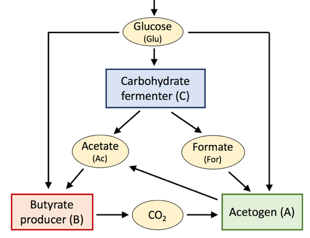

These ecological niches are based on the metabolism of the following three species:

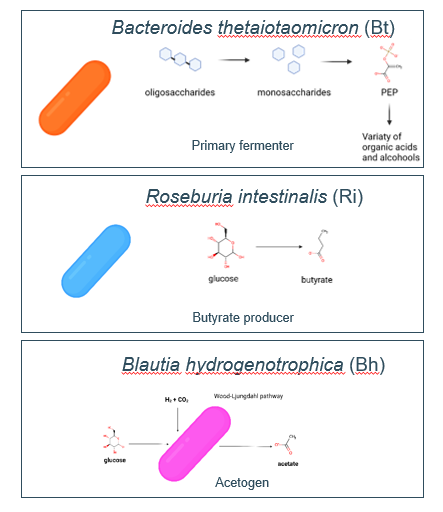

We will run our single-species sampling scenarios using an AGORA model for Bt and only in the community case we will use all three of them. 

### **Technical**

In case your Jupyter notebook does not line with the `sampling` environment, you may give it a shot after running:

In [ ]:
import sys
import os
env_site_packages = os.path.join(os.getenv('CONDA_PREFIX'), 'lib/python3.10/site-packages')  # Adjust for your Python version
if env_site_packages not in sys.path:
    sys.path.append(env_site_packages)

By now, you should be able to load the libraries required for this notebook:

In [2]:
# Libraries
import numpy as np
import pandas as pd 

import cobra
import dingo_walk as dingo

# Local scripts
from scripts.utils import apply_environment
from scripts import mambo

In [3]:
cobra_model = cobra.io.read_sbml_model("files/models/AGORA/Bacteroides_thetaiotaomicron_3731.xml")

In [ ]:
cobra_model.solver

To solve the optimization problems in our model, a solver is required; special software that can solve a wide range of problem types, such as linear programming, mixed-integer linear programming, quadratic programming, mixed-integer quadratic programming etc.
These problems are rather common in metabolic modelling and most of the analyses performed in the field, are based on solivng such optimization problems.

`cobra` uses by default the [Gurobi](https://www.gurobi.com) solver. This solver requires a paid license, but can also [be obtained](https://www.gurobi.com/downloads/) for free under an [academic license](https://www.gurobi.com/downloads/end-user-license-agreement-academic/).

To avoid the need to install Gurobi and set up an academic license, we will use the free `glpk` solver that is already installed when one install `cobrapy`:

In [ ]:
cobra_config = cobra.Configuration()
cobra_config.solver = 'glpk'

And let's have a look on a `cobra` model's basic parts

As you can see, our model is empty, meaning **no metabolites**, **no reactions** are there.

Assume now we have annotated the genome of the strain of interest (in our case a sugar fermenter, pseudo-*Bacteroides thetaiotaomicron*) and we have a list of the reactions it can go for. 

> **Note**
>
> ***Fermentation*** and ***respiration*** are the two major processes aiming at
> generate ATP for cellular functions and for both the first step is glycolysis, i.e. the breakdown of glucose (or other sugars) into pyruvate.
> Their key difference focuses on whether they involve an **Electron Transport Chain** (respiration) or not (fermentation).
> Respiration, when aerobic, ends up producing $CO{_2}$ and $H{_2}0$, while fermentation organic acids (e.g. lactate) or alcohol (e.g., ethanol) and $CO_{2}$.
> Last, respiration can reach up to much higher ATP yield, i.e. ATP molecules per glucose.


*Exchange* reactions are a type of **boundary reactions**.
There are three different types of pre-defined **boundary reactions**. 
All of them are **unbalanced pseudo reactions**, that means they fulfill a function for modeling by **adding to or removing metabolites** from the model system but are **not based on real biolog**y. These reaction types include:

* **exchange:** _reversible_ reactions that **add to** or **remove** an extracellular metabolite **from the extracellular compartment**
* **demand:** _irreversible_ reaction that each consumes an intracellular metabolite. 
* **sink** is similar to an exchange but specifically for intracellular metabolites, i.e., a _reversible_ reaction that adds or removes an intracellular metabolite.

But if there are boundary reactions, that means that our model should have different ***compartments***.
So, here's what's going on:

![open_closed_systems](./files/figs/comp.png)


Actually, if we have a look in the `cobra.Model` instance of ours, we'll notice that last line stands for compartments, that currently, are also empty.

-------

Do you remember the matrix notion from the slides? 

The $S$ matrix represents the **stoichiometric matrix** where *metabolites* are represented in its *rows*, and *reactions* in its *columns*.


$S_{int}$ describes the **internal** reactions and their compounds, in this example case that would be a single reaction ($v_1$) that requires one molecule of A and B to produce one molecule of C.

On the other hand, $S_{exch}$ includes also the exchange reactions, **but not the external metabolites**. Thus, A and B can be uptaken through $b{_1}$ and $b{_2}$ while C can be secreted thanks to $b{_3}$.

-------

## Sampling vs Flux Balance Analysis (FBA)


In our model, we consider the exchange pseudo reactions and assume a **steady state condition**, meaning that there is no accumulation or depletion of compounds; thus, the **rate of production equals the rate of
consumption for each compound** in the network; mass (and energy) is conserved. 

This can be mathematically described by: 

$$ 
S v = 0
$$

where $v$ represents the **flux vector**, a vector with the flux values of each and every reaction in the model.


Constraints however are represented in two ways:

- as **equations** that balance reaction inputs and outputs, and 
- as **inequalities** that impose bounds on the system. 

Let's have a look on what a constraint looks like! 

Let's think of a case where we have a case like the one in the figure above, 
where 

$$ A + B \rightarrow C $$

It's easy for one to guess that the production of $C$ is **constrained** by the reactions providing $A$ and those providing $B$. 
Thus, by the **bounds** of their production. 

Usign the `samples_in_constrain_3D` function, we can visualize this to better understand it.
We need to set the **bounds** of each of the reactions included and a relationship of 

> **Attention!**
> 
> In our implementation you need to give positive boundaries for all three reactions. 
> In an actual model, uptakes are usually handled with negative flux values.



In [ ]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

# This should pop up on a new tab on your browser
samples_in_constraint_3D(
    r1_bounds = [5, 10],
    r2_bounds = [5, 10],
    r3_bounds = [0,  40],
    r3_relationship = [-1, -1]
)


Next, we demonstrate some of the basic functionalities of cobrapy. After this introduction, you should be able to:

1) Load a model object;
    &nbsp;

2) Manipulate metabolite, reaction, and gene objects;
    &nbsp;

3) Solve the model with linear programing, using flux balance analysis (FBA);
    &nbsp;

4) Change the composition of the external environment.
&nbsp;
&nbsp;

**Note**: in this tutorial we often refer to 'objects' such as 'model object', 'reaction object', etc. These are python classes, which contain a number of specific attributes.

#### Solving the model

We can solve the model using flux balance analysis, which maximizes the objective function (usually biomass). This means obtaining the maximum flux value that is allowed to run through our objective function (referred to as the "objective value"). This also gives a solution for the optimal flux of each reaction.


In [ ]:
obj = bt_model.optimize()

print(obj.objective_value)
print("--")
print(obj.fluxes)

For algorithms that require the objective_value in a fast way, use:



In [ ]:
objCoef = bt_model.slim_optimize()
objCoef

In [ ]:
#flux (only accessible after the model is solved)
print('optimal flux: ', acetate_ptransferase.flux)

In [ ]:
#"knock out" a reaction from the model
acetate_ptransferase.lower_bound = 0
acetate_ptransferase.upper_bound = 0

#force flux through a reaction (usually results in an infeasible model)
acetate_ptransferase.upper_bound = 1000
acetate_ptransferase.lower_bound = 10

## A walk through the solution of the FBA

To better understand how constraints define the flux values of an FBA, but also what these fluxes mean for the cell's functions, 
we will use the [Escher online tool](https://sbrg.github.io/escher-fba/#/app) to have a better look at those and to their dynamics. 

Points to notice:

- Is **directionality** always clear ? How could we determine what the model actually suggests about the flux of a reversible reaction ?
- How you interpret the color coding ? What is the meaning of a red flux ? Are those the limiting factors of the model ? 
- What happens if you change the flux of a reaction ? Try for example `glc__D_e` and `PDH`. Do you notice anything on the range of the values the last may get ?



### Flux Variability Analysis

Returns minimum and maximum a flux may get respecting the constraints of the model.

**Remember**

When $v{_i}$ gets a value $x$, $v{_j}$ might need to get specific value $y$, so the system remains at steady state. 

FVA returns **ranges**, not **solutions**.


In [ ]:
modelFolder = os.path.join(os.getcwd(), "files", "models")
ecoli  =  cobra.io.read_sbml_model(os.path.join(modelFolder,'e_coli_core.xml' ))
cobra.flux_analysis.flux_variability_analysis(ecoli)

Let's have a look on the envelope ; built using `fluxpy` -- still in development 

## Sampling the solution space of metabolic models

While FBA finds a single maximum for the objective function, one might be interested in the space of viable metabolisms. This space reveals the range of conditions where the cell could live without the assumption of maximizing an objective function.

The space of viable metabolisms is explored by taking uniform samples from the flux distribution. Besides revealing the cell's metabolic potential, these samples also reveal the conformations of higher likelihood and the burden of regulation needed for the cell to achieve its "maximum growth". In the example below, we compare the point of optimal growth with alternative flux distributions.

In [ ]:
# import the necessary packages and functions
from cobra.sampling import ACHRSampler

#for making the plots
import matplotlib.pyplot as plt
# plt.style.use('seaborn-bright')


**step 2** : load the model, apply the rich media

In [ ]:
model_sf = cobra.io.read_sbml_model(os.path.join(modelFolder,'sugar_fermenter_toy_model.xml' ))


print("Initia medium:", model_sf.medium)
print("Total potential exchange reactions:", model_sf.exchanges)

rich_media = {'EX_cpd00027_e':10,
         'EX_cpd00036_e':10,
         'EX_cpd00159_e':10,
         'EX_cpd00047_e':10,
         'EX_cpd00029_e':10,
         'EX_cpd00067_e':10
         }

apply_environment(model_sf, rich_media)
print(model_sf.medium)

**step 3**: perform sampling

In [ ]:
sol = model_sf.optimize()
z = sol.objective_value #the objective value

#reaction fluxes under the optimal solution
glycolysis = model_sf.reactions.rxn00459.flux
fp = model_sf.reactions.EX_cpd00047_e.flux #formate production
lp = model_sf.reactions.EX_cpd00159_e.flux #lactate production
sp = model_sf.reactions.EX_cpd00036_e.flux #succinate production

achr = ACHRSampler(model_sf, thinning=10) #see https://cobrapy.readthedocs.io/en/latest/sampling.html
s1 = achr.sample(5000) #samples
v = achr.validate(s1)
sample = s1[v=='v'] #keep only the feasible samples

**step 4**: make plots

In [ ]:
fig, ax = plt.subplots()

#sampled biomass vs the sampled glycolysis
ax.scatter(sample.biomass, sample.rxn00459, s=0.1, color='#add8e6', alpha=0.5)

#optimal biomass vs the optimal glycolysis
ax.scatter(sol.objective_value, glycolysis, s=80, color='#add8e6', label = 'Glycolysis', edgecolors='k')

#sampled biomass vs the sampled formate production
ax.scatter(sample.biomass, sample.EX_cpd00047_e, s=0.1, color='purple', alpha=0.5)

#optimal biomass vs the optimal formate production
ax.scatter(sol.objective_value, fp, s=80, color='purple', label = 'Formate prod', edgecolors='k')

#sampled biomass vs the sampled succinate production
ax.scatter(sample.biomass, sample.EX_cpd00036_e, s=0.1, color='orange', alpha=0.5)

#optimal biomass vs the optimal succinate production
ax.scatter(sol.objective_value, sp, s=80, color='orange', label = 'Succinate prod', edgecolors='k')

#sampled biomass vs the sampled lactate production
ax.scatter(sample.biomass, sample.EX_cpd00159_e, s=0.1, color='#00ff9f', alpha=0.5)

#optimal biomass vs the optimal lactate production
ax.scatter(sol.objective_value, lp, s=80, color='#00ff9f', label = 'Lactate prod', edgecolors='k')

ax.set_ylabel('Flux', fontsize=14)
ax.set_xlabel('Biomass flux', fontsize=14)
plt.legend(fontsize='large', fancybox=True, title='Carb. Ferm.', title_fontsize='x-large', loc=2)
plt.xlim(0,z+1)



## Dynamic Flux Balance Analysis

**step 1**: import packages and load models


In [ ]:
from scipy.integrate import solve_ivp as solver
import matplotlib.pyplot as plt
# plt.style.use('seaborn-bright')


model_ac = cobra.io.read_sbml_model(os.path.join(modelFolder,'acetogen_toy_model.xml' ))
model_sf = cobra.io.read_sbml_model(os.path.join(modelFolder,'sugar_fermenter_toy_model.xml' ))
model_bp = cobra.io.read_sbml_model(os.path.join(modelFolder,'butyrate_producer_toy_model.xml' ))


**step 2**: define parameters and initial states

**Parameters**

| parameter | variable | default value |
| --------- | -------- | ------------- |
| acetogen glucose Monod K | ac_glucose_k | 1.0 |
| acetogen glucose yield | ac_glucose_y | 1.0 |
| acetogen formate Monod K | ac_for_k | 10.0 |
| acetogen formate yield | ac_for_y | 1.0 |
| acetogen CO2 Monod K | ac_co2_k | 1.0 |
| acetogen CO2 yield | ac_co2_y | 10.0 |
| acetogen H2 Monod K | ac_h2_k | 10.0 |
| acetogen H2 yield | ac_h2_y | 10.0 |
| acetogen acetate yield | ac_ac_y | -1.0 |
| acetogen lactate yield | ac_lac_y | -1.0 |
| sugarF glucose Monod K | sf_glucose_k | 1.0 |
| sugarF glucose yield | sf_glucose_y | 1.0 |
| sugarF succinate yield | sf_succ_y | -1.0 |
| sugarF formate yield | sf_for_y | -1.0 |
| sugarF lactate yield | sf_lac_y | -1.0 |
| sugarF acetate yield | sf_ac_y | -1.0 |
| butyrateP glucose Monod K | bp_glucose_k | 1.0 |
| butyrateP glucose yield | bp_glucose_y | 1.0 |
| butyrateP lactate consumpation Monod K | bp_lactate_c_k | 1.0 |
| butyrateP lactate consumption yield | bp_lactate_c_y | 1.0 |
| butyrateP lactate production yield | bp_lactate_p_y | -1.0 |
| butyrateP acetate consumpation Monod K | bp_acetate_c_k | 1.0 |
| butyrateP acetate consumption yield | bp_acetate_c_y | 1.0 |
| butyrateP acetate production yield | bp_acetate_p_y | -1.0 |
| butyrateP CO2 production yield | bp_co2_y | -1.0 |
| butyrateP H2 production yield | bp_h2_y | -1.0 |
| butyrateP butyrate production yield | bp_butyrate_y | -1.0 |
| flow rate | flow_rate | 0.1 |


**States**

| state | position | default value |
| ----- | -------- | ------------- |
|glucose concentration | 0 | 10 |
|formate concentration | 1 | 0 |
|CO2 concentration | 2 | 0 |
|H2 concentration | 3 | 0 |
|acetate concentration | 4 | 0 |
|lactate concentration | 5 | 0 |
|succinate concentration | 6 | 0 |
|butyrate concentration | 7 | 0 |
|acetogen biomass | 8 | 0.1 |
|sugarF biomass | 9 | 0.1 |
|butyrateP biomass | 10 | 0.1 |



In [ ]:
parameters = {'ac_glucose_k' : 1.0,
              'ac_glucose_y' : 1.0,
              'ac_for_k' : 10.0,
              'ac_for_y' : 1.00,
              'ac_co2_k' : 1.0,
              'ac_co2_y' : 10.00,
              'ac_h2_k' : 10.0,
              'ac_h2_y' : 1.00,
              'ac_ac_y':-1.0,
              'ac_lac_y':-1.0,
              'sf_glucose_k':1.0,
              'sf_glucose_y':1.0,
              'sf_succ_y':-1.0,
              'sf_for_y':-1.0,
              'sf_lac_y':-1.0,
              'sf_ac_y':-1.0,
              'bp_glucose_k':1.0,
              'bp_glucose_y':1.0,
              'bp_lactate_c_k':1.0,
              'bp_lactate_c_y':1.00,
              'bp_lactate_p_y': -1,
              'bp_acetate_c_k':1.0,
              'bp_acetate_c_y':1.0,
              'bp_acetate_p_y':-1,
              'bp_co2_y': -1,
              'bp_h2_y':-1,
              'bp_butyrate_y':-1,
              'flow_rate':0.1
              }

initial_states = np.array([10, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.1, 0.1])
#glc_S0, for_S0, co2_S0, H2_S0, acetate_S0, lac_S0, succ_S0, but_S0, ac_X0, sf_X0, bp_X0


**step 3**: write growth rate functions ($\mu$) for each bacteria

In [ ]:
def muAc(concentration_vec):
    '''
    growth rate function for the acetogen

    Parameters
    ----------
    concentration_vec :
        [glucose, formate, co2, h2, acetate, lactate, succinate, butyrate]

    Returns
    -------
    consumed_glucose
    consumed_formate
    consumed_co2
    consumed_h2
    produced_acetate
    produced_lactate
    objective_value

    '''


    consumable_glucose = (concentration_vec[0]/(concentration_vec[0]+parameters['ac_glucose_k']))*(concentration_vec[0]>0)
    #(concentration_vec[0]>0) avoids negatives

    consumable_formate = (concentration_vec[1]/(concentration_vec[1]+parameters['ac_for_k']))*(concentration_vec[1]>0)

    consumable_co2 = (concentration_vec[2])/(concentration_vec[2]+parameters['ac_co2_k'])*(concentration_vec[2]>0)

    consumable_h2 = (concentration_vec[3])/(concentration_vec[3]+parameters['ac_h2_k'])*(concentration_vec[3]>0)

    #set the lower bounds to the consumable amounts

    model_ac.reactions.EX_cpd00027_e.lower_bound = -1*consumable_glucose
    model_ac.reactions.EX_cpd00047_e.lower_bound = -1*consumable_formate
    model_ac.reactions.EX_cpd00011_e.lower_bound = -1*consumable_co2
    model_ac.reactions.EX_cpd11640_e.lower_bound = -1*consumable_h2

    #optimize with these consumable amounts as constraints

    sol_ac = model_ac.optimize()

    #get what was effectively consumed/produces
    consumed_glucose = max(0, model_ac.reactions.EX_cpd00027_e.flux*-1)
    consumed_formate = max(0, model_ac.reactions.EX_cpd00047_e.flux*-1)
    consumed_co2 = max(0, model_ac.reactions.EX_cpd00011_e.flux*-1)
    consumed_h2 = max(0, model_ac.reactions.EX_cpd11640_e.flux*-1)

    produced_acetate = max(0, model_ac.reactions.EX_cpd00029_e.flux)
    produced_lactate = max(0, model_ac.reactions.EX_cpd00159_e.flux)

    return (consumed_glucose,
            consumed_formate,
            consumed_co2,
            consumed_h2,
            produced_acetate,
            produced_lactate,
            sol_ac.objective_value #the biomass given the consumable amounts
            )


def muSf(concentration_vec):
    '''

    Growth rate function for the sugarF

    Parameters
    ----------
    concentration_vec :
        [glucose, formate, co2, h2, acetate, lactate, succinate, butyrate]

    Returns
    -------
    consumed_glucose
    produced_acetate
    produced_lactate
    produced_succinate
    produced_formate
    objective_value

    '''



    consumable_glucose = (concentration_vec[0]/(concentration_vec[0]+parameters['sf_glucose_k']))*(concentration_vec[0]>0)

    model_sf.reactions.EX_cpd00027_e.lower_bound = -1*consumable_glucose

    sol_sf = model_sf.optimize()

    consumed_glucose = max(0, model_sf.reactions.EX_cpd00027_e.flux*-1)

    produced_acetate = max(0, model_sf.reactions.EX_cpd00029_e.flux)
    produced_lactate = max(0, model_sf.reactions.EX_cpd00159_e.flux)
    produced_succinate = max(0, model_sf.reactions.EX_cpd00036_e.flux)
    produced_formate = max(0, model_sf.reactions.EX_cpd00047_e.flux)

    return (consumed_glucose,
            produced_acetate,
            produced_lactate,
            produced_succinate,
            produced_formate,
            sol_sf.objective_value
            )


def muBP(concentration_vec):
    '''
    Growth rate for the butyrate producer

    Parameters
    ----------
    concentration_vec :
        [glucose, formate, co2, h2, acetate, lactate, succinate, butyrate]

    Returns
    -------
    consumed_glucose
    consumed_acetate
    consumed_lactate
    produced_acetate
    produced_lactate
    produced_co2
    produced_h2
    produced_butyrate
    sol_bp.objective_value

    '''


    consumable_glucose = (concentration_vec[0]/(concentration_vec[0]+parameters['bp_glucose_k']))*(concentration_vec[0]>0)
    consumable_acetate = (concentration_vec[4]/(concentration_vec[4]+parameters['bp_acetate_c_k']))*(concentration_vec[4]>0)
    consumable_lactate = (concentration_vec[5]/(concentration_vec[5]+parameters['bp_lactate_c_k']))*(concentration_vec[5]>0)

    model_bp.reactions.EX_cpd00027_e.lower_bound = -1*consumable_glucose
    model_bp.reactions.EX_cpd00029_e.lower_bound = -1*consumable_acetate
    model_bp.reactions.EX_cpd00159_e.lower_bound = -1*consumable_lactate


    sol_bp = model_bp.optimize()
    consumed_glucose = max(0, model_bp.reactions.EX_cpd00027_e.flux*-1)
    consumed_acetate = 0
    produced_acetate = 0
    consumed_lactate = 0
    produced_lactate = 0

    #acetate was consumed instead of produced
    if model_bp.reactions.EX_cpd00029_e.flux<0:
        consumed_acetate = model_bp.reactions.EX_cpd00029_e.flux*-1

    #lactate was consumed instead of produced
    if model_bp.reactions.EX_cpd00159_e.flux<0:
        consumed_lactate = model_bp.reactions.EX_cpd00159_e.flux*-1


    #acetate was produced
    if model_bp.reactions.EX_cpd00029_e.flux>0:
        produced_acetate = model_bp.reactions.EX_cpd00029_e.flux

    #lactate was produced
    if model_bp.reactions.EX_cpd00159_e.flux>0:
        produced_lactate = model_bp.reactions.EX_cpd00159_e.flux


    produced_co2 = max(0, model_bp.reactions.EX_cpd00011_e.flux)
    produced_h2 = max(0, model_bp.reactions.EX_cpd11640_e.flux)
    produced_butyrate = max(0, model_bp.reactions.EX_cpd00211_e.flux)

    return (consumed_glucose,
            consumed_acetate,
            consumed_lactate,
            produced_acetate,
            produced_lactate,
            produced_co2,
            produced_h2,
            produced_butyrate,
            sol_bp.objective_value
            )



**Step 4**: define the ordinary differential equation (ODE) that updates the states (see the table containing the 11 states above)

In [ ]:
def ode(t, states):

    '''
    ODE
    states:
        [glc_S0, for_S0, co2_S0, H2_S0, acetate_S0, lac_S0, succ_S0, but_S0, ac_X0, sf_X0, bp_X0]
    '''

    #get the metabolite consumption/production and instantaneous growth rates
    mu_ac = muAc(states)
    mu_sf = muSf(states)
    mu_bp = muBP(states)

    #get the current biomasses
    pop_ac = states[8]
    pop_sf = states[9]
    pop_bp = states[10]

    #change in the acetogen biomass
    dAc = (pop_ac* mu_ac[-1])-parameters['flow_rate']*pop_ac

    #change in the sugarF biomass
    dSf = (pop_sf* mu_sf[-1]) - parameters['flow_rate']*pop_sf

    #change in the butyrateP biomass
    dBp = (pop_bp*mu_bp[-1])- parameters['flow_rate']*pop_bp

    #acetogen metabolite consumption/production
    ac_glc = -(mu_ac[0]/parameters['ac_glucose_y'])*pop_ac
    ac_for = -(mu_ac[1]/parameters['ac_for_y'])*pop_ac
    ac_co2 = -(mu_ac[2]/parameters['ac_co2_y'])*pop_ac
    ac_h2 = -(mu_ac[3]/parameters['ac_h2_y'])*pop_ac
    ac_ac = -(mu_ac[4]/parameters['ac_ac_y'])*pop_ac
    ac_lac = -(mu_ac[5]/parameters['ac_lac_y'])*pop_ac

    #sugarF metabolite consumption/production
    sf_glc = -(mu_sf[0]/parameters['sf_glucose_y'])*pop_sf
    sf_ac = -(mu_sf[1]/parameters['sf_ac_y'])*pop_sf
    sf_lac = -(mu_sf[2]/parameters['sf_lac_y'])*pop_sf
    sf_succ = -(mu_sf[3]/parameters['sf_succ_y'])*pop_sf
    sf_for = -(mu_sf[4]/parameters['sf_for_y'])*pop_sf

    #butyrateP metabolite consumption/production
    bp_glc = -(mu_bp[0]/parameters['bp_glucose_y'])*pop_bp
    bp_ac_c = -(mu_bp[1]/parameters['bp_acetate_c_y'])*pop_bp
    bp_lac_c = -(mu_bp[2]/parameters['bp_lactate_c_y'])*pop_bp

    bp_ac_p = -(mu_bp[3]/parameters['bp_acetate_p_y'])*pop_bp
    bp_lac_p = -(mu_bp[4]/parameters['bp_lactate_p_y'])*pop_bp
    bp_co2_p = -(mu_bp[5]/parameters['bp_co2_y'])*pop_bp
    bp_h2_p = -(mu_bp[6]/parameters['bp_h2_y'])*pop_bp
    bp_but_p = -(mu_bp[7]/parameters['bp_butyrate_y'])*pop_bp


    derivatives = np.zeros(len(states))

    #glucose
    derivatives[0] = parameters['flow_rate']*initial_states[0] + ac_glc + sf_glc + bp_glc - parameters['flow_rate']*states[0]

    #formate
    derivatives[1] = parameters['flow_rate']*initial_states[1] + ac_for + sf_for  - parameters['flow_rate']*states[1]

    #co2
    derivatives[2] = parameters['flow_rate']*initial_states[2] + ac_co2 + bp_co2_p  - parameters['flow_rate']*states[2]

    #h2
    derivatives[3] = parameters['flow_rate']*initial_states[3] + ac_h2 + bp_h2_p  - parameters['flow_rate']*states[3]

    #acetate
    derivatives[4] = parameters['flow_rate']*initial_states[4] + ac_ac + sf_ac + bp_ac_c + bp_ac_p  - parameters['flow_rate']*states[4]

    #lactate
    derivatives[5] = parameters['flow_rate']*initial_states[5] + ac_lac + sf_lac + bp_lac_c + bp_lac_p  - parameters['flow_rate']*states[5]

    #succinate
    derivatives[6] = parameters['flow_rate']*initial_states[6] + sf_succ  - parameters['flow_rate']*states[6]

    #butyrate
    derivatives[7] = parameters['flow_rate']*initial_states[7] + bp_but_p  - parameters['flow_rate']*states[7]

    derivatives[8] = dAc
    derivatives[9] = dSf
    derivatives[10] = dBp

    return derivatives


**Step 5**: solve the initial value problem for the ODE

In [ ]:
solution = solver(fun=ode, t_span = (0, 800), y0 = initial_states, t_eval = np.linspace(0, 800, 1000))

**Step 6**: plot the results for the biomass

In [ ]:
fig, ax = plt.subplots()

ax.plot(solution.t, solution.y[8], color='g', label='acetogen')
ax.plot(solution.t, solution.y[9], color='b', label='carb ferm')
ax.plot(solution.t, solution.y[10], color='r', label='but prod')
ax.set_ylabel('Biomass')
ax.set_xlabel('Time')
ax.legend(loc='upper right')
plt.show()

**Step 7**: plot the results for the metabolites

In [ ]:
fig, ax = plt.subplots()

ax.plot(solution.t, solution.y[0], color='#0776c0', label='Glucose')

ax.plot(solution.t, solution.y[4], color='#db571a', label='Acetate')

ax.plot(solution.t, solution.y[1], color='#edb320', label='Formate')

ax.plot(solution.t, solution.y[2], color='#7e2c8d', label='CO2')
ax.plot(solution.t, solution.y[3], color='#7e2c8d', label='H2')

ax.plot(solution.t, solution.y[5], color='#00ff9f', label='Lactate')
ax.plot(solution.t, solution.y[6], color='#32CD32', label='Succinate')
ax.plot(solution.t, solution.y[7], color='#001eff', label='Butyrate')


ax.set_ylabel('Concentration')
ax.set_xlabel('Time')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


## Tasks

### Model manipulation (Level 1)



Make a summary table containing all the reactions in the toy models with the following fields:

- Id

- Name
- Reaction string with metabolite names
- Lower bound
- Upper bound
- Reversibility
- Type (internal, objective, transport, sink, exchange)
- SugarFermenter (1 if present in the sugar fermenter, 0 otherwise)
- ButyrateProducer (1 if present in the butyrate producer, 0 otherwise)
- Acetogen (1 if present in the acetogen, 0 otherwise)


#### genes

The model object also contais genes.


In [ ]:
# change to the 'full' model
import os
modelFolder = os.path.join(os.getcwd(), "files", "models")
model = cobra.io.read_sbml_model(os.path.join(modelFolder,'e_coli_core.xml' ))


print(model.genes)

gene1 = model.genes[0]

print('name: ', gene1.name, '\n')

print('id: ', gene1.id, '\n')

print('reactions:', gene1.reactions)
print([i.name for i in gene1.reactions])

Note that a single gene can explain several reactions and a reaction may be explained by one or more genes. Boolean rules may be applied to explain if the reaction is an isozyme (OR) or part of a complex (AND).

In [ ]:
for i in gene1.reactions:
    print(i.gene_reaction_rule)

Gapfilled reactions and some others (sink, exchange) do not have genes associated to them:

In [ ]:
geneless = [i.id for i in model.reactions if i.genes == frozenset()]

print(geneless)

note the toy models do not contain any genes associated to them.

In [ ]:
model = cobra.io.read_sbml_model(os.path.join(modelFolder,'acetogen_toy_model.xml' ))

print(len(model.genes))

### Model manipulation (Level 2)

- Find reactions that are essential for the model to produce biomass (pick any of the toy models)

- Find reactions that are only essential in pairs

- Repeat the above, but now find reaction and reaction pairs that reduce the model’s biomass by up to an arbitrary threshold (i.e. 10%)

- **bonus task**: find a metabolite-set that is always essential for your picked model to grow.

#### Changing the environment

The metabolites are made available to the models through the exchange reactions (see above).

To 'control' the composition, set the lower bound. But take into account that these are constrained-based models. To 'force' the models to consume a defined amount, set the lower and upper bound to this amount (this often leads to unfeasible models)

In [ ]:
# provide a rich media
for i in model.exchanges:
    i.lower_bound = -1000

obj = model.optimize()

print('rich media: ', obj.objective_value, '\n')


# remove glucose
model.reactions.EX_cpd00027_e.lower_bound=0

obj = model.optimize()

print('no glucose: ', obj.objective_value, '\n')

# force a glucose flux

model.reactions.EX_cpd00027_e.lower_bound=-30
model.reactions.EX_cpd00027_e.upper_bound=-30
obj = model.optimize()

print('forced glucose flux: ', obj.objective_value, '\n')

print('glucose flux: ',
model.reactions.EX_cpd00027_e.flux)


In [ ]:
model.medium

### Model manipulation (Level 3)

- Generate random environment compositions and associate them to the production of biomass by the three toy models

- Compare their growth rate distributions across these random environments (making box plots should be enough)

- Make the same comparison without glucose

- **bonus task**: repeat the above in an environment with a fixed high and low sugar concentration.


AGORA models under `files/models/AGORA`:

- [*Bacteroides thetaiotaomicron* 3731](https://vmh.life/files/reconstructions/AGORA2/version2.01/sbml_files/individual_reconstructions/Bacteroides_thetaiotaomicron_3731.xml)

- [*Blautia hydrogenotrophica* DSM 10507](https://vmh.life/files/reconstructions/AGORA2/version2.01/sbml_files/individual_reconstructions/Blautia_hydrogenotrophica_DSM_10507.xml)

- [*Roseburia_intestinalis* L1 82](https://vmh.life/files/reconstructions/AGORA2/version2.01/sbml_files/individual_reconstructions/Roseburia_intestinalis_L1_82.xml)



In [ ]:
import dingo_walk as dingo

# Blautia
bh_agora_model   = dingo.MetabolicNetwork.from_sbml("Blautia_hydrogenotrophica_DSM_10507.xml")
sampler          = dingo.PolytopeSampler(model)
bh_agora_samples = sampler.generate_steady_states()

# Bacteroides
bt_agora_model   = dingo.MetabolicNetwork.from_sbml("Bacteroides_thetaiotaomicron_3731.xml")
sampler          = dingo.PolytopeSampler(bt_agora_model)
bt_agora_samples = sampler.generate_steady_states()

# Roseburia
ri_agora_model   = dingo.MetabolicNetwork.from_sbml("Roseburia_intestinalis_L1_82.xml")
sampler          = dingo.PolytopeSampler(ri_agora_model)
ri_agora_samples = sampler.generate_steady_states()

